In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;  #makes graph colors pretty
from gensim.summarization import keywords
from __future__ import print_function
import os
import re
import string
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
sns.set()
sns.palplot(sns.color_palette("muted"))

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

stage1_solution_filtered.csv
stage_2_private_solution.csv
stage2_sample_submission.csv
stage2_test_text.csv
stage2_test_variants.csv
test_text
test_variants
training_text
training_variants



In [3]:
train_var = pd.read_csv("../input/training_variants")
test_var = pd.read_csv("../input/stage2_test_variants.csv")
train_text = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("../input/stage2_test_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
#dataframe.shape returns a tuple representing dimensionality
# print("Train and Test variants shape : ",train_var.shape, test_var.shape)
# print("Train and Test text shape : ",train_text.shape, test_text.shape)

In [4]:
#dataframe.head returns first 5 rows
#training variants
train_var.head()
train_var.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


In [5]:
#returns first 5 rows of training text
train_text.head()
train_text.describe(include='all')

,ID,Text
count,3321.000000,3316
unique,NaN,1920
top,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,53
mean,1660.000000,NaN
std,958.834449,NaN
min,0.000000,NaN
25%,830.000000,NaN
50%,1660.000000,NaN
75%,2490.000000,NaN


In [6]:
# train_data = pd.concat([train_var_df.set_index('ID'),
#                         train_text_df.set_index('ID')],axis=1)
train_data = pd.merge(train_var, train_text, how='left',on = 'ID').fillna('')
train_data['ID'] = train_data.ID.astype(int)
train_y = train_data['Class'].values
train_x = train_data.drop('Class',axis=1)
train_size=len(train_x)
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
train_data.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [8]:
#dataframe.head returns first 5 rows
#test variants
test_var.head()

,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


In [9]:
#returns first 5 rows of test text
test_text.head()

,ID,Text
0,1,The incidence of breast cancer is increasing i...
1,2,An unselected series of 310 colorectal carcino...
2,3,Mycosis fungoides and Sézary syndrome are prim...
3,4,Regulated progression through the cell cycle ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [10]:
# test_data = pd.concat([test_var_df.set_index('ID'),
#                         test_text_df.set_index('ID')],axis=1)
test_data = pd.merge(test_var, test_text, how='left',on = 'ID').fillna('')
test_data['ID'] = test_data.ID.astype(int)
test_data.head()

,ID,Gene,Variation,Text
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [11]:
test_data.describe(include='all')

,ID,Gene,Variation,Text
count,986.000000,986,986,986
unique,NaN,279,945,874
top,NaN,TP53,Truncating Mutations,Among the best-studied therapeutic targets in ...
freq,NaN,40,18,24
mean,493.500000,NaN,NaN,NaN
std,284.777984,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,247.250000,NaN,NaN,NaN
50%,493.500000,NaN,NaN,NaN
75%,739.750000,NaN,NaN,NaN


In [12]:
#print 1st row from training text dataframe
with open("../input/training_text") as infile:
    for i in range(0,2):
        line = infile.readline()

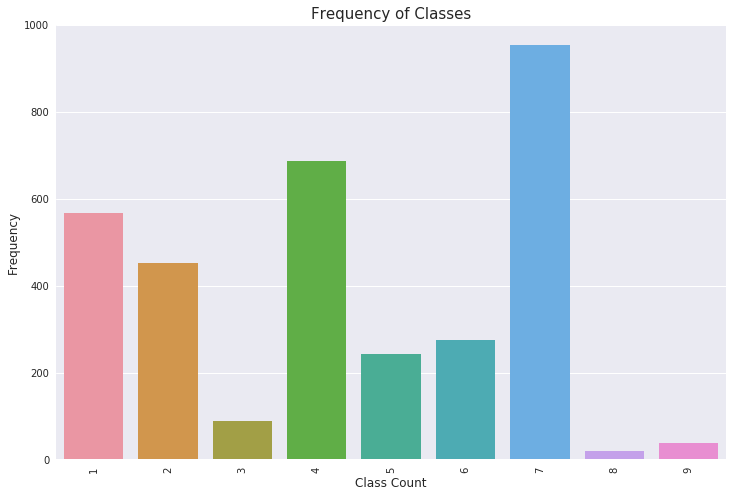

In [13]:
#frequency of classes in training data
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_var)
plt.xlabel('Class Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [14]:
#First column is Class
#Second column is Frequency
#All in training variants file
data = train_var
data["Class"].value_counts()      

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [15]:
#print(train_data)
train_data['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [16]:
test_index = test_data['ID'].values
all_data = np.concatenate((train_x, test_data), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]
all_data['ID'] = all_data.ID.astype(int)
# print (all_data.dtypes)
all_data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [17]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
# import spacy

from gensim.models import doc2vec
from gensim import utils
from sklearn.feature_extraction import stop_words
from spacy.lang.en.stop_words import STOP_WORDS

In [18]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show","them",'study','case','syndrome', 
                'author', 'show', 'control', 'expression','supplementary',
                'result', 'figure','fig', 'level', 'deletion', 'mm',
                'state', 'effect', 'stability', 'activity','change','structure',
                'line', 'loss', 'expression' '"', "’", "“", "”", "disease",
                "diseases", "disorder", "symptom", "symptoms", "drug", "drugs",
                "problems", "problem","prob", "probs", "med", "meds",
                "pill", "pills", "medicine", "medicines", "medication", "medications",
                "treatment", "treatments", "caps", "capsules", "capsule",
                "tablet", "tablets", "tabs", "doctor", "dr"," dr."," doc",
                "physician", "physicians", "test", "tests", "testing",
                "specialist", "specialists","side-effect", "side-effects", 
                "pharmaceutical", "pharmaceuticals", "pharma", "diagnosis",
                "diagnose", "diagnosed"," exam","challenge", "device", "condition",
                "conditions", "suffer", "suffering" ,"suffered", "feel"," feeling",
                "prescription", "prescribe","prescribed", "over-the-counter", "otc"]

In [19]:
def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(doc2vec.TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [20]:
def textClean(text):
    #only including alphanumeric symbols
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english") + custom_words)
    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops and w.isalpha() and stop_words.ENGLISH_STOP_WORDS and STOP_WORDS] 
    text = " ".join(text)
    return(text)

In [21]:
def cleanup(text):
    text = textClean(text)
    #gets rid of punctuations
    text = text.translate(str.maketrans("","", string.punctuation))
    
    return text

In [22]:
Text_INPUT_DIM=300
text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = doc2vec.Doc2Vec.load(filename)
else:    
    allText = all_data['Text'].apply(cleanup)
    #allText.head()
    sentences = constructLabeledSentences(allText)
    sentences[0]
    
    #doc2vec
    #workers is the number of threads
    #window 
    #using words you have to create to vectorize
    #have all words in model and 
    #use that model to create the array
    #window is distance between current and predicted word
    #sample the threshold for configuring which higher-frequency words are randomly downsampled, useful range is
    #negative specifies how many noise words should be drawn
    #epochs (int) – Number of iterations (epochs) over the corpus.
    text_model = doc2vec.Doc2Vec(min_count=1, window=3,vector_size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, epochs=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

In [23]:
    # from nltk.tokenize import word_tokenize
    # from nltk.stem import WordNetLemmatizer
    # from nltk.corpus import stopwords
    # from string import punctuation
    # import spacy

    # #did not lemmatize words use Spacy lemmatizer
    # from nltk.corpus import stopwords
    # from gensim.models.doc2vec import TaggedDocument
    # from gensim import utils
    # import gensim
    # from sklearn.feature_extraction import stop_words
    # import spacy
    # tokens = []
    # lemma = []
    # pos = []



    # nlp = spacy.load("en")
    # stops = stopwords.words("english")

    # def normalize(comment, lowercase, remove_stopwords):
    #     if lowercase:
    #         comment = comment.lower()
    #     comment = nlp(comment)
    #     lemmatized = list()
    #     for word in comment:
    #         lemma = word.lemma_.strip()
    #         if lemma:
    #             if not remove_stopwords or (remove_stopwords and lemma not in stops):
    #                 lemmatized.append(lemma)
    #     return " ".join(lemmatized)


    # def cleanup(text):
    #     text = textClean(text)
    #     #gets rid of punctiations
    #     text= text.translate(str.maketrans("","", string.punctuation))
    #     return text

    # allText = all_data['Text'].apply(normalize, lowercase=True, remove_stopwords=True)
    # print(allText)


    # sentences = constructLabeledSentences(allText)
    # sentences[0]

In [24]:
test_size =(len(test_data))
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

#never train with test set so you split training data into 
#training and validaition sets

#vectorization of training text
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0

#vectorizing test data
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1

#vector for each id
#3321 points in 300 dimensional space
#text_train_arrays[0] is first vector
#len(text_train_arrays[0]) = 300
# 3321 indices
#print("Size of text_train_arrays:")

# print (len(text_train_arrays))
#print (len(text_train_arrays[0]))
# print(text_train_arrays[0])
#print(text_train_arrays[0][:50])

In [25]:
from sklearn.decomposition import TruncatedSVD
#n_components is number of dimenstions you want
Gene_INPUT_DIM=25
#we use the new k-dimensional LSI representation as we did the original
#representation – to compute similarities between vectors

#one hot encoding is representation of categorical to binary
#categoral values mapped to integer values
#integer value represented as binary vector as all zeros except index of integer
#
svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

#pd.get_dummies gets one hot encodings
one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
#truncated = list of vectors 25 dimensions each vector representing a hot gene
one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
# print (one_hot_gene)
# print(truncated_one_hot_gene[0])

In [26]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#train_y = train['Class'].values
#train_y is classes
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
# #print(encoded_y[0])
# print(encoded_y)
# print(len(encoded_y))

In [27]:
#np.hstack concatenates arrays together
#train_set is array of 300+25+25
#vectorized one hot gene/variation/and text

#same thing with test set
#vectorized all important info
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
# print(len(text_train_arrays))
#first 50 dimensions of first 
# print(len(train_set[0]))
# print(train_set[0])
#print(train_set[0][:50])

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
#connecting each neuron to next neuron to next layer(Dense)

#dense is connecting layers together
#dropout - randomly draw connections between neurons
#Text_INPUT_DIM=300 = input_dim = expected 300 variables
#total input dimension is 350
#fully connected layers are defined using the Dense class
def baseline_model():
    #sequental is linear stack of layers
    #pass list of layers
    model = Sequential()
    model.add(Dense(1024, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(9, init='normal', activation="softmax"))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=False)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [29]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              359424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 2313      
Total params: 624,137
Trainable params: 624,137
Non-trainable params: 0
_________________________________________________________________


/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, input_dim=350, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
/home/sasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`


In [30]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

In [31]:
#validation for training accuracy
#accuracy 
#validation
#valuation loss
#80% train data 20% validation data
#validation 
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=80, batch_size=512)

Train on 2656 samples, validate on 665 samples
Epoch 1/80
2656/2656 [==============================] - 0s 137us/step - loss: 2.1415 - acc: 0.1785 - val_loss: 1.9913 - val_acc: 0.3188
Epoch 2/80
2656/2656 [==============================] - 0s 44us/step - loss: 1.9393 - acc: 0.2779 - val_loss: 1.9165 - val_acc: 0.3789
Epoch 3/80
2656/2656 [==============================] - 0s 46us/step - loss: 1.8419 - acc: 0.3185 - val_loss: 1.8519 - val_acc: 0.3805
Epoch 4/80
2656/2656 [==============================] - 0s 41us/step - loss: 1.7792 - acc: 0.3535 - val_loss: 1.7848 - val_acc: 0.3789
Epoch 5/80
2656/2656 [==============================] - 0s 44us/step - loss: 1.7556 - acc: 0.3731 - val_loss: 1.7531 - val_acc: 0.3820
Epoch 6/80
2656/2656 [==============================] - 0s 47us/step - loss: 1.7201 - acc: 0.3938 - val_loss: 1.7425 - val_acc: 0.3714
Epoch 7/80
2656/2656 [==============================] - 0s 42us/step - loss: 1.6980 - acc: 0.3908 - val_loss: 1.6975 - val_acc: 0.3910
Epoch 8

2656/2656 [==============================] - 0s 36us/step - loss: 1.2245 - acc: 0.5527 - val_loss: 1.5270 - val_acc: 0.4165
Epoch 60/80
2656/2656 [==============================] - 0s 40us/step - loss: 1.2210 - acc: 0.5448 - val_loss: 1.5139 - val_acc: 0.4195
Epoch 61/80
2656/2656 [==============================] - 0s 38us/step - loss: 1.2091 - acc: 0.5572 - val_loss: 1.5201 - val_acc: 0.4165
Epoch 62/80
2656/2656 [==============================] - 0s 40us/step - loss: 1.2133 - acc: 0.5602 - val_loss: 1.5154 - val_acc: 0.4150
Epoch 63/80
2656/2656 [==============================] - 0s 41us/step - loss: 1.1898 - acc: 0.5644 - val_loss: 1.5209 - val_acc: 0.4150
Epoch 64/80
2656/2656 [==============================] - 0s 35us/step - loss: 1.1973 - acc: 0.5648 - val_loss: 1.5097 - val_acc: 0.4241
Epoch 65/80
2656/2656 [==============================] - 0s 31us/step - loss: 1.1975 - acc: 0.5580 - val_loss: 1.5048 - val_acc: 0.4211
Epoch 66/80
2656/2656 [==============================] - 0s 

In [32]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 59.41% / Validation accuracy: 41.20%


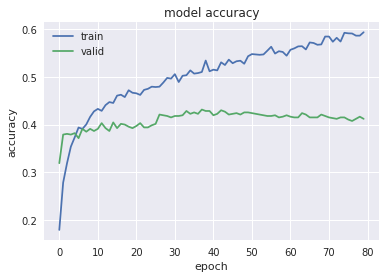

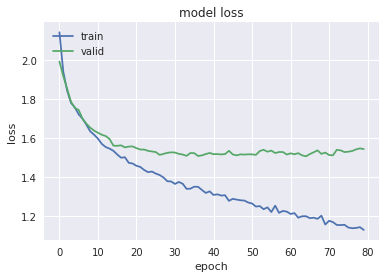

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
y_pred = model.predict_proba(test_set)

In [35]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission = submission[['id', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']]

In [36]:
submission.to_csv("submission_all.csv",index=False)
submission.head()
# print(submission)

,id,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.236652,0.018481,0.026383,0.522035,0.077821,0.088654,0.022198,0.003426,0.004350
1,2,0.684414,0.001300,0.001254,0.298984,0.005505,0.002467,0.005118,0.000409,0.000549
2,3,0.221087,0.197815,0.037482,0.059626,0.059831,0.051120,0.335527,0.021108,0.016405
3,4,0.088270,0.281285,0.010715,0.036416,0.034569,0.049544,0.436040,0.030060,0.033101
4,5,0.020538,0.195195,0.024805,0.041923,0.035025,0.020408,0.642348,0.010532,0.009225


In [37]:
from keras import backend as K

layer_of_interest = 0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [38]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

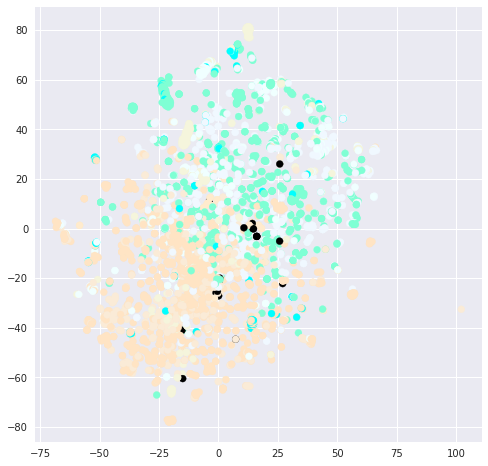

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()